# Setup

In [68]:
%load_ext autoreload
%autoreload 2
import tool_kit as tk
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
images = tk.load_data_image()
images.head()

,image_id,nb_cells,mask,blur
0,SIMCEPImages_D07_C27_F10_s03_w2.TIF,27,no,10
1,SIMCEPImages_I24_C100_F26_s04_w2.TIF,100,no,26
2,SIMCEPImages_O18_C74_F45_s13_w1.TIF,74,no,45
3,SIMCEPImages_J11_C44_F29_s20_w1.TIF,44,no,29
4,SIMCEPImages_M11_C44_F39_s08_w2.TIF,44,no,39


## Separation test set et train set

In [83]:
import numpy as np
import pandas as pd

unseen = images[images['mask'] == 'no']
df_image_mask  = images[images['mask'] == 'yes']

df_test_set = df_image_mask.sample(frac=0.2, random_state=42)
df_train_set = df_image_mask.drop(df_test_set.index)
df_train_set.drop('mask', axis=1, inplace=True)
df_test_set.drop('mask', axis=1, inplace=True)
len(df_test_set), len(df_train_set)

(240, 960)

## Test d'affichage d'une image

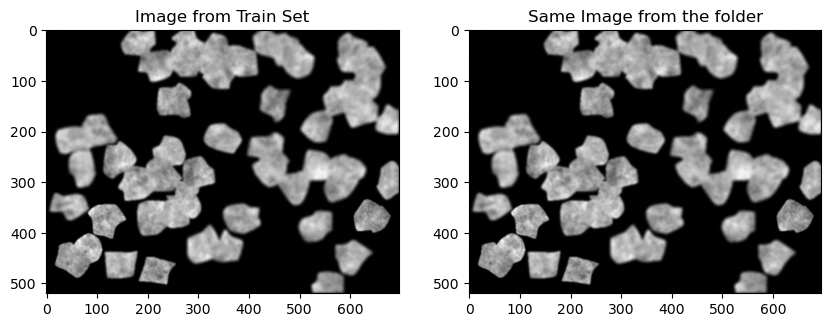

In [93]:
import cv2
folder = 'dataset/archive/BBBC005_v1_images/BBBC005_v1_images'
test_image = cv2.imread(folder + '/' + df_train_set["image_id"].iloc[0], cv2.IMREAD_GRAYSCALE)


import matplotlib.pyplot as plt
train_set = tk.data_to_matrix(df_train_set,'image')

fig , axes = plt.subplots(1,2 , figsize=(10,5))
axes[0].imshow(train_set[0], cmap='gray')
axes[0].set_title("Image from Train Set")  # Adding a title

axes[1].imshow(test_image, cmap='gray')
axes[1].set_title("Same Image from the folder")  # Adding a title
plt.show()

In [95]:
import torch
import torch.nn as nn

"""
Il n'y a pas de dropout pour le moment peut etre à ajouter par la suite
"""
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# Définir une couche d'up-sampling (déconvolution)
'''
On utilise ConvTranspose2d pour effectuer une convolution transposée (déconvolution)
à la place de upsampling comme ca on a des poids à apprendre.
'''
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        return self.up(x)

# Fonction pour effectuer un "center crop" d'un tenseur car image pas carré
def center_crop(tensor, target_tensor):
    _, _, h, w = target_tensor.size()  # Get target height and width
    tensor_h, tensor_w = tensor.size(2), tensor.size(3)
    
    # Calculate the cropping needed
    delta_h = (tensor_h - h) // 2
    delta_w = (tensor_w - w) // 2
    
    return tensor[:, :, delta_h:(delta_h + h), delta_w:(delta_w + w)]


class unet(nn.Module):

    def __init__(self):
        super(unet, self).__init__()

        # Partie encoder (contracting path)
        self.encoder1 = ConvBlock(1, 64)
        self.encoder2 = ConvBlock(64, 128)
        self.encoder3 = ConvBlock(128, 256)
        self.encoder4 = ConvBlock(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Partie bottleneck
        self.bottleneck = ConvBlock(512, 1024)

        # Partie decoder (expansive path)
        self.upconv4 = UpConv(1024, 512)
        self.decoder4 = ConvBlock(1024, 512)
        self.upconv3 = UpConv(512, 256)
        self.decoder3 = ConvBlock(512, 256)
        self.upconv2 = UpConv(256, 128)
        self.decoder2 = ConvBlock(256, 128)
        self.upconv1 = UpConv(128, 64)
        self.decoder1 = ConvBlock(128, 64)
        
        # Couche de sortie
        self.conv_out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder
        d4 = self.upconv4(b)
        e4 = center_crop(e4, d4) 
        d4 = torch.cat((e4, d4), dim=1)  # skip connection
        d4 = self.decoder4(d4)
        
        d3 = self.upconv3(d4)
        e3 = center_crop(e3, d3) 
        d3 = torch.cat((e3, d3), dim=1)  # skip connection
        d3 = self.decoder3(d3)
        
        d2 = self.upconv2(d3)
        e2 = center_crop(e2, d2)
        d2 = torch.cat((e2, d2), dim=1)  # skip connection
        d2 = self.decoder2(d2)
        
        d1 = self.upconv1(d2)
        e1 = center_crop(e1, d1)
        d1 = torch.cat((e1, d1), dim=1)  # skip connection
        d1 = self.decoder1(d1)
        
        # Sortie
        return self.conv_out(d1)

model = unet()

In [98]:
from torchsummary import summary

img_weight , img_height = train_set[0].shape
summary(model, (1, img_weight, img_height))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 520, 696]             640
       BatchNorm2d-2         [-1, 64, 520, 696]             128
              ReLU-3         [-1, 64, 520, 696]               0
            Conv2d-4         [-1, 64, 520, 696]          36,928
       BatchNorm2d-5         [-1, 64, 520, 696]             128
              ReLU-6         [-1, 64, 520, 696]               0
         ConvBlock-7         [-1, 64, 520, 696]               0
         MaxPool2d-8         [-1, 64, 260, 348]               0
            Conv2d-9        [-1, 128, 260, 348]          73,856
      BatchNorm2d-10        [-1, 128, 260, 348]             256
             ReLU-11        [-1, 128, 260, 348]               0
           Conv2d-12        [-1, 128, 260, 348]         147,584
      BatchNorm2d-13        [-1, 128, 260, 348]             256
             ReLU-14        [-1, 128, 2

In [99]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [57]:
def training(epoch = 10):
    for i in range(epoch):
        for matrix in train_set:
            optimizer.zero_grad()
            matrix = torch.tensor(matrix).unsqueeze(0).unsqueeze(0).float()
            output = model(matrix)
            loss = criterion(output, matrix)
            loss.backward()
            optimizer.step()
            print('loss:', loss.item())
            print('epoch :' , i)

In [ ]:
training()